In [106]:
from tensorflow import keras

dataset = keras.utils.image_dataset_from_directory(
    "./타자얼굴사진_GAN/",
    label_mode = None,
    image_size = (256, 256),
    batch_size = 16,
    smart_resize = True
)

Found 66 files belonging to 1 classes.


In [107]:
dataset = dataset.map(lambda x : x/255.)

In [108]:
dataset

<MapDataset shapes: (None, 256, 256, 3), types: tf.float32>

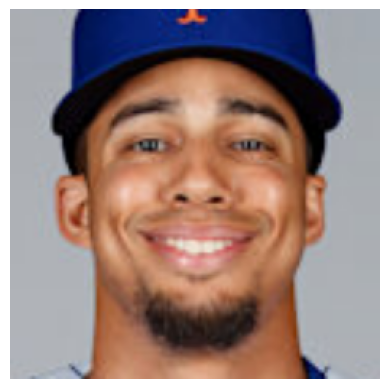

In [109]:
import matplotlib.pyplot as plt
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

# 판별자
## GAN 판별자 네트워크

In [110]:
from tensorflow.keras import layers

discriminator = keras.Sequential(
    [
        keras.Input(shape = (256,256,3)),
        layers.Conv2D(64, kernel_size = 4, strides = 2, padding = "same"),
        layers.LeakyReLU(alpha = 0.2),
        layers.Conv2D(128, kernel_size = 4, strides = 2, padding = "same"),
        layers.LeakyReLU(alpha = 0.2),
        layers.Conv2D(128, kernel_size = 4, strides = 2, padding = "same"),
        layers.LeakyReLU(alpha = 0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation = "sigmoid")
    ],
    name = "discriminator")

In [111]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 128, 128, 64)      0         
                                                                 
 conv2d_23 (Conv2D)          (None, 64, 64, 128)       131200    
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 32, 32, 128)       262272    
                                                                 
 leaky_re_lu_37 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 flatten_4 (Flatten)         (None, 131072)          

In [101]:
8*8*128

8192

In [112]:
32*32*128

131072

# 생성자
## GAN 생성자 네트워크

In [113]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape = (latent_dim,)),
        layers.Dense(32 * 32 * 128),
        layers.Reshape((32, 32, 128)),
        layers.Conv2DTranspose(128, kernel_size = 4, strides = 2, padding = "same"),
        layers.LeakyReLU(alpha = 0.2),
        layers.Conv2DTranspose(256, kernel_size = 4, strides = 2, padding = "same"),
        layers.LeakyReLU(alpha = 0.2),
        layers.Conv2DTranspose(512, kernel_size = 4, strides = 2, padding = "same"),
        layers.LeakyReLU(alpha = 0.2),
        layers.Conv2D(3, kernel_size = 5, padding = "same", activation = "sigmoid")
        
    ],
    name = "generator")

In [114]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 131072)            16908288  
                                                                 
 reshape_7 (Reshape)         (None, 32, 32, 128)       0         
                                                                 
 conv2d_transpose_21 (Conv2D  (None, 64, 64, 128)      262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_38 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 conv2d_transpose_22 (Conv2D  (None, 128, 128, 256)    524544    
 Transpose)                                                      
                                                                 
 leaky_re_lu_39 (LeakyReLU)  (None, 128, 128, 256)     0 

In [115]:
import tensorflow as tf
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

In [116]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

In [119]:
epochs = 2000

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/2000
5/5 [==============================] - 4s 502ms/step - d_loss: 0.4090 - g_loss: 2.4748
Epoch 2/2000
5/5 [==============================] - 3s 484ms/step - d_loss: 0.2586 - g_loss: 3.4720
Epoch 3/2000
5/5 [==============================] - 2s 471ms/step - d_loss: 0.3691 - g_loss: 2.8925
Epoch 4/2000
5/5 [==============================] - 2s 474ms/step - d_loss: 0.6145 - g_loss: 1.8508
Epoch 5/2000
5/5 [==============================] - 2s 475ms/step - d_loss: 0.7719 - g_loss: 0.9477
Epoch 6/2000
5/5 [==============================] - 2s 470ms/step - d_loss: 0.7064 - g_loss: 1.4166
Epoch 7/2000
5/5 [==============================] - 2s 471ms/step - d_loss: 0.3570 - g_loss: 2.2397
Epoch 8/2000
5/5 [==============================] - 2s 467ms/step - d_loss: 0.2927 - g_loss: 1.9561
Epoch 9/2000
5/5 [==============================] - 2s 464ms/step - d_loss: 0.3876 - g_loss: 2.3543
Epoch 10/2000
5/5 [==============================] - 2s 488ms/step - d_loss: 0.7196 - g_loss: 1.3315

5/5 [==============================] - 2s 459ms/step - d_loss: 0.4569 - g_loss: 1.7532
Epoch 83/2000
5/5 [==============================] - 2s 463ms/step - d_loss: 0.6571 - g_loss: 1.6985
Epoch 84/2000
5/5 [==============================] - 2s 456ms/step - d_loss: 0.6192 - g_loss: 1.3062
Epoch 85/2000
5/5 [==============================] - 2s 472ms/step - d_loss: 0.3117 - g_loss: 2.0635
Epoch 86/2000
5/5 [==============================] - 2s 470ms/step - d_loss: 0.2168 - g_loss: 2.8678
Epoch 87/2000
5/5 [==============================] - 2s 474ms/step - d_loss: 0.2725 - g_loss: 2.0387
Epoch 88/2000
5/5 [==============================] - 2s 467ms/step - d_loss: 0.6530 - g_loss: 1.6939
Epoch 89/2000
5/5 [==============================] - 2s 473ms/step - d_loss: 0.8654 - g_loss: 1.0578
Epoch 90/2000
5/5 [==============================] - 2s 468ms/step - d_loss: 1.0529 - g_loss: 0.7900
Epoch 91/2000
5/5 [==============================] - 2s 477ms/step - d_loss: 0.7931 - g_loss: 1.4960
Epoc

5/5 [==============================] - 2s 483ms/step - d_loss: 0.4278 - g_loss: 2.4661
Epoch 163/2000
5/5 [==============================] - 3s 505ms/step - d_loss: 0.6769 - g_loss: 1.8858
Epoch 164/2000
5/5 [==============================] - 2s 485ms/step - d_loss: 0.6052 - g_loss: 1.6606
Epoch 165/2000
5/5 [==============================] - 2s 475ms/step - d_loss: 0.8424 - g_loss: 1.4771
Epoch 166/2000
5/5 [==============================] - 3s 482ms/step - d_loss: 1.0776 - g_loss: 1.4411
Epoch 167/2000
5/5 [==============================] - 3s 483ms/step - d_loss: 1.5832 - g_loss: 1.1249
Epoch 168/2000
5/5 [==============================] - 3s 498ms/step - d_loss: 1.2936 - g_loss: 1.7862
Epoch 169/2000
5/5 [==============================] - 2s 479ms/step - d_loss: 0.6451 - g_loss: 1.8752
Epoch 170/2000
5/5 [==============================] - 2s 463ms/step - d_loss: 0.1885 - g_loss: 3.3819
Epoch 171/2000
5/5 [==============================] - 2s 479ms/step - d_loss: 0.1895 - g_loss: 3.

5/5 [==============================] - 3s 494ms/step - d_loss: 0.5676 - g_loss: 1.1015
Epoch 243/2000
5/5 [==============================] - 2s 483ms/step - d_loss: 0.5968 - g_loss: 1.1238
Epoch 244/2000
5/5 [==============================] - 2s 492ms/step - d_loss: 0.6034 - g_loss: 0.9224
Epoch 245/2000
5/5 [==============================] - 2s 468ms/step - d_loss: 0.4922 - g_loss: 1.3654
Epoch 246/2000
5/5 [==============================] - 2s 489ms/step - d_loss: 0.5169 - g_loss: 1.2700
Epoch 247/2000
5/5 [==============================] - 2s 470ms/step - d_loss: 0.5046 - g_loss: 1.5043
Epoch 248/2000
5/5 [==============================] - 2s 494ms/step - d_loss: 0.6624 - g_loss: 1.0985
Epoch 249/2000
5/5 [==============================] - 2s 468ms/step - d_loss: 0.7354 - g_loss: 1.4750
Epoch 250/2000
5/5 [==============================] - 2s 484ms/step - d_loss: 0.6365 - g_loss: 1.2964
Epoch 251/2000
5/5 [==============================] - 2s 469ms/step - d_loss: 0.4008 - g_loss: 1.

5/5 [==============================] - 2s 463ms/step - d_loss: 0.6113 - g_loss: 1.8518
Epoch 323/2000
5/5 [==============================] - 3s 492ms/step - d_loss: 0.5903 - g_loss: 1.0653
Epoch 324/2000
5/5 [==============================] - 2s 468ms/step - d_loss: 0.4832 - g_loss: 1.5797
Epoch 325/2000
5/5 [==============================] - 2s 482ms/step - d_loss: 0.3690 - g_loss: 1.5180
Epoch 326/2000
5/5 [==============================] - 3s 502ms/step - d_loss: 0.2862 - g_loss: 2.1154
Epoch 327/2000
5/5 [==============================] - 2s 476ms/step - d_loss: 0.3291 - g_loss: 1.9602
Epoch 328/2000
5/5 [==============================] - 3s 496ms/step - d_loss: 0.3900 - g_loss: 1.9299
Epoch 329/2000
5/5 [==============================] - 2s 481ms/step - d_loss: 0.5502 - g_loss: 2.1255
Epoch 330/2000
5/5 [==============================] - 2s 489ms/step - d_loss: 0.5018 - g_loss: 1.5676
Epoch 331/2000
5/5 [==============================] - 3s 493ms/step - d_loss: 0.5444 - g_loss: 1.

5/5 [==============================] - 2s 461ms/step - d_loss: 0.7360 - g_loss: 1.4618
Epoch 403/2000
5/5 [==============================] - 3s 498ms/step - d_loss: 0.3481 - g_loss: 1.9763
Epoch 404/2000
5/5 [==============================] - 3s 488ms/step - d_loss: 0.1910 - g_loss: 1.9910
Epoch 405/2000
5/5 [==============================] - 2s 465ms/step - d_loss: 0.2097 - g_loss: 2.6872
Epoch 406/2000
5/5 [==============================] - 3s 498ms/step - d_loss: 0.3731 - g_loss: 1.9357
Epoch 407/2000
5/5 [==============================] - 2s 486ms/step - d_loss: 0.5359 - g_loss: 1.3028
Epoch 408/2000
5/5 [==============================] - 2s 471ms/step - d_loss: 0.6715 - g_loss: 1.2785
Epoch 409/2000
5/5 [==============================] - 2s 471ms/step - d_loss: 0.9031 - g_loss: 1.2522
Epoch 410/2000
5/5 [==============================] - 3s 503ms/step - d_loss: 0.7378 - g_loss: 1.0664
Epoch 411/2000
5/5 [==============================] - 3s 485ms/step - d_loss: 0.6542 - g_loss: 1.

5/5 [==============================] - 2s 482ms/step - d_loss: 0.2796 - g_loss: 1.8125
Epoch 483/2000
5/5 [==============================] - 2s 481ms/step - d_loss: 0.2728 - g_loss: 2.0488
Epoch 484/2000
5/5 [==============================] - 2s 459ms/step - d_loss: 0.3703 - g_loss: 1.7856
Epoch 485/2000
5/5 [==============================] - 2s 478ms/step - d_loss: 0.5048 - g_loss: 1.7015
Epoch 486/2000
5/5 [==============================] - 2s 489ms/step - d_loss: 0.6473 - g_loss: 0.9880
Epoch 487/2000
5/5 [==============================] - 2s 463ms/step - d_loss: 0.8360 - g_loss: 1.2989
Epoch 488/2000
5/5 [==============================] - 2s 461ms/step - d_loss: 0.9136 - g_loss: 0.7687
Epoch 489/2000
5/5 [==============================] - 2s 478ms/step - d_loss: 0.7779 - g_loss: 0.8483
Epoch 490/2000
5/5 [==============================] - 3s 487ms/step - d_loss: 0.6965 - g_loss: 1.2160
Epoch 491/2000
5/5 [==============================] - 2s 480ms/step - d_loss: 0.6215 - g_loss: 0.

5/5 [==============================] - 2s 464ms/step - d_loss: 0.3613 - g_loss: 1.7875
Epoch 563/2000
5/5 [==============================] - 3s 505ms/step - d_loss: 0.2833 - g_loss: 1.5143
Epoch 564/2000
5/5 [==============================] - 3s 490ms/step - d_loss: 0.2075 - g_loss: 2.2188
Epoch 565/2000
5/5 [==============================] - 2s 476ms/step - d_loss: 0.2498 - g_loss: 2.5835
Epoch 566/2000
5/5 [==============================] - 2s 462ms/step - d_loss: 0.2582 - g_loss: 1.8507
Epoch 567/2000
5/5 [==============================] - 2s 469ms/step - d_loss: 0.4455 - g_loss: 1.7613
Epoch 568/2000
5/5 [==============================] - 2s 473ms/step - d_loss: 0.7001 - g_loss: 1.1435
Epoch 569/2000
5/5 [==============================] - 2s 484ms/step - d_loss: 0.9932 - g_loss: 1.0583
Epoch 570/2000
5/5 [==============================] - 2s 454ms/step - d_loss: 0.5616 - g_loss: 2.0809
Epoch 571/2000
5/5 [==============================] - 2s 458ms/step - d_loss: 0.6597 - g_loss: 2.

5/5 [==============================] - 2s 457ms/step - d_loss: 0.9160 - g_loss: 1.6002
Epoch 643/2000
5/5 [==============================] - 2s 478ms/step - d_loss: 0.8428 - g_loss: 1.7999
Epoch 644/2000
5/5 [==============================] - 2s 473ms/step - d_loss: 0.4659 - g_loss: 2.0341
Epoch 645/2000
5/5 [==============================] - 3s 484ms/step - d_loss: 0.2890 - g_loss: 2.8717
Epoch 646/2000
5/5 [==============================] - 2s 459ms/step - d_loss: 0.2650 - g_loss: 2.7645
Epoch 647/2000
5/5 [==============================] - 2s 467ms/step - d_loss: 0.4457 - g_loss: 2.2141
Epoch 648/2000
5/5 [==============================] - 2s 489ms/step - d_loss: 0.6165 - g_loss: 1.4680
Epoch 649/2000
5/5 [==============================] - 3s 491ms/step - d_loss: 0.5468 - g_loss: 1.6393
Epoch 650/2000
5/5 [==============================] - 3s 493ms/step - d_loss: 0.5674 - g_loss: 1.2688
Epoch 651/2000
5/5 [==============================] - 2s 470ms/step - d_loss: 0.4338 - g_loss: 2.

5/5 [==============================] - 2s 457ms/step - d_loss: 0.6359 - g_loss: 1.6140
Epoch 723/2000
5/5 [==============================] - 2s 473ms/step - d_loss: 0.7556 - g_loss: 1.1894
Epoch 724/2000
5/5 [==============================] - 2s 479ms/step - d_loss: 0.7250 - g_loss: 1.5122
Epoch 725/2000
5/5 [==============================] - 3s 482ms/step - d_loss: 0.7362 - g_loss: 1.2658
Epoch 726/2000
5/5 [==============================] - 3s 487ms/step - d_loss: 0.7216 - g_loss: 1.1172
Epoch 727/2000
5/5 [==============================] - 2s 453ms/step - d_loss: 0.5891 - g_loss: 1.3907
Epoch 728/2000
5/5 [==============================] - 2s 456ms/step - d_loss: 0.5101 - g_loss: 1.3814
Epoch 729/2000
5/5 [==============================] - 3s 489ms/step - d_loss: 0.4324 - g_loss: 1.4141
Epoch 730/2000
5/5 [==============================] - 2s 483ms/step - d_loss: 0.3818 - g_loss: 1.5036
Epoch 731/2000
5/5 [==============================] - 2s 474ms/step - d_loss: 0.4219 - g_loss: 1.

5/5 [==============================] - 3s 490ms/step - d_loss: 0.3769 - g_loss: 2.4513
Epoch 803/2000
5/5 [==============================] - 3s 486ms/step - d_loss: 0.4780 - g_loss: 1.6443
Epoch 804/2000
5/5 [==============================] - 2s 482ms/step - d_loss: 0.4756 - g_loss: 1.6259
Epoch 805/2000
5/5 [==============================] - 2s 473ms/step - d_loss: 0.4913 - g_loss: 1.9313
Epoch 806/2000
5/5 [==============================] - 2s 455ms/step - d_loss: 0.4928 - g_loss: 1.3478
Epoch 807/2000
5/5 [==============================] - 2s 454ms/step - d_loss: 0.6431 - g_loss: 1.3097
Epoch 808/2000
5/5 [==============================] - 2s 463ms/step - d_loss: 0.8783 - g_loss: 1.1664
Epoch 809/2000
5/5 [==============================] - 3s 479ms/step - d_loss: 0.9266 - g_loss: 0.7132
Epoch 810/2000
5/5 [==============================] - 2s 471ms/step - d_loss: 0.9438 - g_loss: 1.1902
Epoch 811/2000
5/5 [==============================] - 2s 476ms/step - d_loss: 0.5651 - g_loss: 1.

5/5 [==============================] - 2s 468ms/step - d_loss: 0.8373 - g_loss: 1.2098
Epoch 883/2000
5/5 [==============================] - 2s 467ms/step - d_loss: 1.5729 - g_loss: 0.7322
Epoch 884/2000
5/5 [==============================] - 2s 469ms/step - d_loss: 0.5745 - g_loss: 2.3088
Epoch 885/2000
5/5 [==============================] - 2s 490ms/step - d_loss: 0.1734 - g_loss: 2.6922
Epoch 886/2000
5/5 [==============================] - 2s 451ms/step - d_loss: 0.2542 - g_loss: 2.4612
Epoch 887/2000
5/5 [==============================] - 2s 457ms/step - d_loss: 0.4789 - g_loss: 1.7155
Epoch 888/2000
5/5 [==============================] - 2s 459ms/step - d_loss: 0.6064 - g_loss: 1.1750
Epoch 889/2000
5/5 [==============================] - 2s 472ms/step - d_loss: 0.7305 - g_loss: 0.9428
Epoch 890/2000
5/5 [==============================] - 2s 478ms/step - d_loss: 0.8761 - g_loss: 1.1337
Epoch 891/2000
5/5 [==============================] - 2s 479ms/step - d_loss: 0.7978 - g_loss: 1.

5/5 [==============================] - 2s 472ms/step - d_loss: 0.5818 - g_loss: 1.3489
Epoch 963/2000
5/5 [==============================] - 2s 467ms/step - d_loss: 0.5522 - g_loss: 1.4067
Epoch 964/2000
5/5 [==============================] - 3s 491ms/step - d_loss: 0.4992 - g_loss: 1.1262
Epoch 965/2000
5/5 [==============================] - 2s 479ms/step - d_loss: 0.4688 - g_loss: 1.3972
Epoch 966/2000
5/5 [==============================] - 2s 469ms/step - d_loss: 0.4836 - g_loss: 1.6259
Epoch 967/2000
5/5 [==============================] - 2s 452ms/step - d_loss: 0.4970 - g_loss: 1.3603
Epoch 968/2000
5/5 [==============================] - 2s 452ms/step - d_loss: 0.4568 - g_loss: 1.6532
Epoch 969/2000
5/5 [==============================] - 2s 480ms/step - d_loss: 0.5282 - g_loss: 1.7317
Epoch 970/2000
5/5 [==============================] - 2s 479ms/step - d_loss: 0.6976 - g_loss: 1.0547
Epoch 971/2000
5/5 [==============================] - 2s 476ms/step - d_loss: 0.5757 - g_loss: 1.

5/5 [==============================] - 2s 483ms/step - d_loss: 0.4585 - g_loss: 2.0782
Epoch 1043/2000
5/5 [==============================] - 3s 485ms/step - d_loss: 0.7430 - g_loss: 1.3707
Epoch 1044/2000
5/5 [==============================] - 2s 468ms/step - d_loss: 0.6600 - g_loss: 1.6156
Epoch 1045/2000
5/5 [==============================] - 2s 475ms/step - d_loss: 0.5125 - g_loss: 1.3486
Epoch 1046/2000
5/5 [==============================] - 2s 474ms/step - d_loss: 0.3477 - g_loss: 1.9881
Epoch 1047/2000
5/5 [==============================] - 2s 450ms/step - d_loss: 0.2770 - g_loss: 1.8755
Epoch 1048/2000
5/5 [==============================] - 2s 454ms/step - d_loss: 0.4334 - g_loss: 1.7172
Epoch 1049/2000
5/5 [==============================] - 2s 456ms/step - d_loss: 0.6430 - g_loss: 1.3041
Epoch 1050/2000
5/5 [==============================] - 2s 472ms/step - d_loss: 0.7422 - g_loss: 1.3470
Epoch 1051/2000
5/5 [==============================] - 3s 482ms/step - d_loss: 0.5350 - g

5/5 [==============================] - 2s 479ms/step - d_loss: 0.3806 - g_loss: 1.8366
Epoch 1122/2000
5/5 [==============================] - 2s 487ms/step - d_loss: 0.3636 - g_loss: 1.5735
Epoch 1123/2000
5/5 [==============================] - 2s 482ms/step - d_loss: 0.5320 - g_loss: 1.9771
Epoch 1124/2000
5/5 [==============================] - 2s 477ms/step - d_loss: 0.6250 - g_loss: 1.1083
Epoch 1125/2000
5/5 [==============================] - 2s 477ms/step - d_loss: 0.9385 - g_loss: 1.7019
Epoch 1126/2000
5/5 [==============================] - 2s 458ms/step - d_loss: 0.7713 - g_loss: 1.2309
Epoch 1127/2000
5/5 [==============================] - 2s 463ms/step - d_loss: 0.6458 - g_loss: 1.6229
Epoch 1128/2000
5/5 [==============================] - 2s 454ms/step - d_loss: 0.4742 - g_loss: 1.6319
Epoch 1129/2000
5/5 [==============================] - 2s 476ms/step - d_loss: 0.3515 - g_loss: 2.9995
Epoch 1130/2000
5/5 [==============================] - 2s 476ms/step - d_loss: 0.3936 - g

5/5 [==============================] - 2s 460ms/step - d_loss: 0.4852 - g_loss: 1.9143
Epoch 1201/2000
5/5 [==============================] - 2s 456ms/step - d_loss: 0.5864 - g_loss: 1.3179
Epoch 1202/2000
5/5 [==============================] - 2s 457ms/step - d_loss: 0.4426 - g_loss: 1.3066
Epoch 1203/2000
5/5 [==============================] - 2s 460ms/step - d_loss: 0.3645 - g_loss: 1.7546
Epoch 1204/2000
5/5 [==============================] - 2s 476ms/step - d_loss: 0.4392 - g_loss: 1.7650
Epoch 1205/2000
5/5 [==============================] - 3s 489ms/step - d_loss: 0.4461 - g_loss: 1.6356
Epoch 1206/2000
5/5 [==============================] - 2s 472ms/step - d_loss: 0.5921 - g_loss: 1.2217
Epoch 1207/2000
5/5 [==============================] - 2s 473ms/step - d_loss: 0.6240 - g_loss: 1.3405
Epoch 1208/2000
5/5 [==============================] - 2s 482ms/step - d_loss: 0.7622 - g_loss: 1.1878
Epoch 1209/2000
5/5 [==============================] - 2s 476ms/step - d_loss: 0.6924 - g

5/5 [==============================] - 2s 473ms/step - d_loss: 0.7602 - g_loss: 1.3274
Epoch 1280/2000
5/5 [==============================] - 2s 454ms/step - d_loss: 0.4778 - g_loss: 1.2937
Epoch 1281/2000
5/5 [==============================] - 2s 453ms/step - d_loss: 0.3600 - g_loss: 2.3643
Epoch 1282/2000
5/5 [==============================] - 2s 449ms/step - d_loss: 0.3483 - g_loss: 1.6542
Epoch 1283/2000
5/5 [==============================] - 2s 457ms/step - d_loss: 0.3037 - g_loss: 2.0638
Epoch 1284/2000
5/5 [==============================] - 2s 478ms/step - d_loss: 0.4754 - g_loss: 1.6045
Epoch 1285/2000
5/5 [==============================] - 3s 488ms/step - d_loss: 0.4396 - g_loss: 1.8344
Epoch 1286/2000
5/5 [==============================] - 2s 473ms/step - d_loss: 0.6941 - g_loss: 1.2823
Epoch 1287/2000
5/5 [==============================] - 3s 486ms/step - d_loss: 0.6951 - g_loss: 1.7355
Epoch 1288/2000
5/5 [==============================] - 2s 475ms/step - d_loss: 0.4950 - g

5/5 [==============================] - 3s 494ms/step - d_loss: 0.4550 - g_loss: 1.6012
Epoch 1359/2000
5/5 [==============================] - 2s 478ms/step - d_loss: 0.4616 - g_loss: 1.5897
Epoch 1360/2000
5/5 [==============================] - 2s 479ms/step - d_loss: 0.3788 - g_loss: 1.5911
Epoch 1361/2000
5/5 [==============================] - 2s 474ms/step - d_loss: 0.3790 - g_loss: 1.5602
Epoch 1362/2000
5/5 [==============================] - 2s 474ms/step - d_loss: 0.4303 - g_loss: 1.2363
Epoch 1363/2000
5/5 [==============================] - 2s 472ms/step - d_loss: 0.5018 - g_loss: 1.5053
Epoch 1364/2000
5/5 [==============================] - 2s 480ms/step - d_loss: 0.4356 - g_loss: 1.5409
Epoch 1365/2000
5/5 [==============================] - 2s 459ms/step - d_loss: 0.4501 - g_loss: 1.3722
Epoch 1366/2000
5/5 [==============================] - 2s 460ms/step - d_loss: 0.5907 - g_loss: 1.6529
Epoch 1367/2000
5/5 [==============================] - 2s 460ms/step - d_loss: 0.4183 - g

5/5 [==============================] - 3s 492ms/step - d_loss: 0.4705 - g_loss: 1.3255
Epoch 1438/2000
5/5 [==============================] - 3s 485ms/step - d_loss: 0.3875 - g_loss: 1.8040
Epoch 1439/2000
5/5 [==============================] - 3s 479ms/step - d_loss: 0.4727 - g_loss: 1.5139
Epoch 1440/2000
5/5 [==============================] - 3s 492ms/step - d_loss: 0.5378 - g_loss: 1.5654
Epoch 1441/2000
5/5 [==============================] - 2s 493ms/step - d_loss: 0.5667 - g_loss: 1.2682
Epoch 1442/2000
5/5 [==============================] - 3s 491ms/step - d_loss: 0.6865 - g_loss: 1.3285
Epoch 1443/2000
5/5 [==============================] - 3s 487ms/step - d_loss: 0.4551 - g_loss: 1.7874
Epoch 1444/2000
5/5 [==============================] - 2s 460ms/step - d_loss: 0.3743 - g_loss: 1.5566
Epoch 1445/2000
5/5 [==============================] - 2s 462ms/step - d_loss: 0.4865 - g_loss: 1.9595
Epoch 1446/2000
5/5 [==============================] - 2s 454ms/step - d_loss: 0.5582 - g

5/5 [==============================] - 2s 464ms/step - d_loss: 0.5065 - g_loss: 1.0731
Epoch 1517/2000
5/5 [==============================] - 2s 461ms/step - d_loss: 0.6646 - g_loss: 1.9021
Epoch 1518/2000
5/5 [==============================] - 2s 456ms/step - d_loss: 0.6567 - g_loss: 1.1348
Epoch 1519/2000
5/5 [==============================] - 2s 471ms/step - d_loss: 0.6708 - g_loss: 1.9077
Epoch 1520/2000
5/5 [==============================] - 3s 492ms/step - d_loss: 0.6034 - g_loss: 1.4199
Epoch 1521/2000
5/5 [==============================] - 3s 515ms/step - d_loss: 0.4173 - g_loss: 1.4250
Epoch 1522/2000
5/5 [==============================] - 3s 489ms/step - d_loss: 0.3236 - g_loss: 1.6250
Epoch 1523/2000
5/5 [==============================] - 3s 496ms/step - d_loss: 0.3812 - g_loss: 1.6924
Epoch 1524/2000
5/5 [==============================] - 3s 503ms/step - d_loss: 0.4074 - g_loss: 1.5613
Epoch 1525/2000
5/5 [==============================] - 3s 494ms/step - d_loss: 0.4256 - g

5/5 [==============================] - 3s 487ms/step - d_loss: 0.5038 - g_loss: 1.3356
Epoch 1596/2000
5/5 [==============================] - 3s 494ms/step - d_loss: 0.4100 - g_loss: 1.1269
Epoch 1597/2000
5/5 [==============================] - 2s 480ms/step - d_loss: 0.3375 - g_loss: 1.8629
Epoch 1598/2000
5/5 [==============================] - 3s 486ms/step - d_loss: 0.3067 - g_loss: 1.8622
Epoch 1599/2000
5/5 [==============================] - 3s 499ms/step - d_loss: 0.3981 - g_loss: 1.6638
Epoch 1600/2000
5/5 [==============================] - 3s 497ms/step - d_loss: 0.4078 - g_loss: 1.4487
Epoch 1601/2000
5/5 [==============================] - 3s 488ms/step - d_loss: 0.4624 - g_loss: 1.3042
Epoch 1602/2000
5/5 [==============================] - 2s 460ms/step - d_loss: 0.5539 - g_loss: 1.4334
Epoch 1603/2000
5/5 [==============================] - 2s 460ms/step - d_loss: 0.5306 - g_loss: 1.4447
Epoch 1604/2000
5/5 [==============================] - 2s 460ms/step - d_loss: 0.4199 - g

5/5 [==============================] - 2s 487ms/step - d_loss: 0.4374 - g_loss: 1.8978
Epoch 1675/2000
5/5 [==============================] - 2s 487ms/step - d_loss: 0.4206 - g_loss: 1.3203
Epoch 1676/2000
5/5 [==============================] - 3s 484ms/step - d_loss: 0.4860 - g_loss: 1.7548
Epoch 1677/2000
5/5 [==============================] - 2s 485ms/step - d_loss: 0.4304 - g_loss: 1.2595
Epoch 1678/2000
5/5 [==============================] - 3s 499ms/step - d_loss: 0.4139 - g_loss: 1.9738
Epoch 1679/2000
5/5 [==============================] - 2s 469ms/step - d_loss: 0.4732 - g_loss: 1.2765
Epoch 1680/2000
5/5 [==============================] - 2s 457ms/step - d_loss: 0.4256 - g_loss: 1.4453
Epoch 1681/2000
5/5 [==============================] - 2s 464ms/step - d_loss: 0.4906 - g_loss: 1.2327
Epoch 1682/2000
5/5 [==============================] - 2s 461ms/step - d_loss: 0.4258 - g_loss: 1.2566
Epoch 1683/2000
5/5 [==============================] - 2s 458ms/step - d_loss: 0.4452 - g

5/5 [==============================] - 2s 482ms/step - d_loss: 0.3958 - g_loss: 1.6639
Epoch 1754/2000
5/5 [==============================] - 3s 501ms/step - d_loss: 0.3986 - g_loss: 1.4266
Epoch 1755/2000
5/5 [==============================] - 2s 482ms/step - d_loss: 0.3893 - g_loss: 1.5217
Epoch 1756/2000
5/5 [==============================] - 3s 485ms/step - d_loss: 0.4202 - g_loss: 1.6290
Epoch 1757/2000
5/5 [==============================] - 3s 499ms/step - d_loss: 0.4604 - g_loss: 1.2224
Epoch 1758/2000
5/5 [==============================] - 3s 489ms/step - d_loss: 0.4471 - g_loss: 1.1982
Epoch 1759/2000
5/5 [==============================] - 3s 489ms/step - d_loss: 0.4564 - g_loss: 1.2683
Epoch 1760/2000
5/5 [==============================] - 3s 485ms/step - d_loss: 0.4734 - g_loss: 1.3372
Epoch 1761/2000
5/5 [==============================] - 2s 483ms/step - d_loss: 0.4606 - g_loss: 1.1592
Epoch 1762/2000
5/5 [==============================] - 2s 464ms/step - d_loss: 0.4132 - g

5/5 [==============================] - 3s 490ms/step - d_loss: 0.4146 - g_loss: 1.6183
Epoch 1833/2000
5/5 [==============================] - 2s 464ms/step - d_loss: 0.4898 - g_loss: 1.3983
Epoch 1834/2000
5/5 [==============================] - 2s 466ms/step - d_loss: 0.4041 - g_loss: 1.3663
Epoch 1835/2000
5/5 [==============================] - 2s 466ms/step - d_loss: 0.3748 - g_loss: 1.8514
Epoch 1836/2000
5/5 [==============================] - 2s 466ms/step - d_loss: 0.5206 - g_loss: 1.3635
Epoch 1837/2000
5/5 [==============================] - 2s 462ms/step - d_loss: 0.5753 - g_loss: 1.2672
Epoch 1838/2000
5/5 [==============================] - 3s 500ms/step - d_loss: 0.4533 - g_loss: 1.4378
Epoch 1839/2000
5/5 [==============================] - 3s 489ms/step - d_loss: 0.4090 - g_loss: 1.4011
Epoch 1840/2000
5/5 [==============================] - 3s 498ms/step - d_loss: 0.3672 - g_loss: 1.7324
Epoch 1841/2000
5/5 [==============================] - 3s 493ms/step - d_loss: 0.4275 - g

5/5 [==============================] - 2s 456ms/step - d_loss: 0.3840 - g_loss: 1.9661
Epoch 1912/2000
5/5 [==============================] - 2s 462ms/step - d_loss: 0.3243 - g_loss: 1.5094
Epoch 1913/2000
5/5 [==============================] - 2s 489ms/step - d_loss: 0.4067 - g_loss: 1.7801
Epoch 1914/2000
5/5 [==============================] - 2s 486ms/step - d_loss: 0.3846 - g_loss: 1.6855
Epoch 1915/2000
5/5 [==============================] - 2s 479ms/step - d_loss: 0.4009 - g_loss: 1.8423
Epoch 1916/2000
5/5 [==============================] - 3s 484ms/step - d_loss: 0.4389 - g_loss: 1.7739
Epoch 1917/2000
5/5 [==============================] - 2s 488ms/step - d_loss: 0.4080 - g_loss: 1.4184
Epoch 1918/2000
5/5 [==============================] - 3s 490ms/step - d_loss: 0.4019 - g_loss: 1.6062
Epoch 1919/2000
5/5 [==============================] - 3s 497ms/step - d_loss: 0.3769 - g_loss: 1.4636
Epoch 1920/2000
5/5 [==============================] - 3s 503ms/step - d_loss: 0.3053 - g

5/5 [==============================] - 2s 469ms/step - d_loss: 0.4405 - g_loss: 1.6246
Epoch 1991/2000
5/5 [==============================] - 2s 465ms/step - d_loss: 0.4401 - g_loss: 1.5239
Epoch 1992/2000
5/5 [==============================] - 3s 486ms/step - d_loss: 0.3084 - g_loss: 1.5849
Epoch 1993/2000
5/5 [==============================] - 3s 479ms/step - d_loss: 0.4476 - g_loss: 1.7118
Epoch 1994/2000
5/5 [==============================] - 3s 502ms/step - d_loss: 0.3477 - g_loss: 1.7442
Epoch 1995/2000
5/5 [==============================] - 2s 479ms/step - d_loss: 0.3841 - g_loss: 1.4243
Epoch 1996/2000
5/5 [==============================] - 2s 484ms/step - d_loss: 0.3569 - g_loss: 1.4268
Epoch 1997/2000
5/5 [==============================] - 3s 491ms/step - d_loss: 0.4360 - g_loss: 1.7670
Epoch 1998/2000
5/5 [==============================] - 3s 497ms/step - d_loss: 0.3665 - g_loss: 1.6519
Epoch 1999/2000
5/5 [==============================] - 3s 493ms/step - d_loss: 0.4349 - g